In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from util import *

In [2]:
train_dir = 'training/'
test_dir = 'validation/'

In [3]:
# Information about the data set
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
info = pd.read_csv("monkey_labels.txt", names=cols, skiprows=1)

In [4]:
info

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


(367, 550, 3)


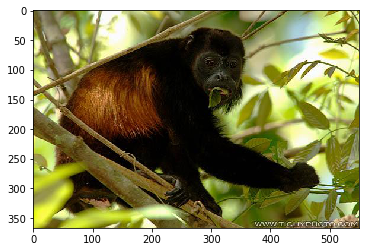

In [5]:
# Sample image
img = plt.imread('training/n0/n0018.jpg')
print(img.shape)
plt.imshow(img)

In [6]:
labels = info['Common Name']

## Resize input images
- We use the image augmentation module from Keras to rescale the images sizes to be compatible with the Xception module

In [7]:
from keras.preprocessing.image import ImageDataGenerator

HEIGHT = 299
WIDTH = 299
CHANNELS = 3
BATCH_SIZE = 32

# Use ImageDataGenerator function to rescale the picture size
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')
# test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')


/home/jun/Dropbox/CS/.env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


## Generate features using Xception module

In [8]:
from keras.applications import Xception

# base_model that imports Xception module without
# the top fully-connected layer
base_model = Xception(weights='imagenet',
                      include_top=False,
                      input_shape=(HEIGHT,WIDTH,CHANNELS))

In [9]:
# Forward-pass the rescaled images using the pretrained Xception module
def extract_features(sample_count, generator):
    
    start = time.time()
    features =  np.zeros(shape=(sample_count, 10, 10, 2048))
    labels = np.zeros(shape=(sample_count,10))
    
    i = 0
    for inputs_batch,labels_batch in generator:
        stop = time.time()
        dt = stop - start
        print('\r',
              'Extracting features from batch', str(i+1), '/', len(generator),
              '-- run time:', dt,'seconds',
              end='')
        
        features_batch = base_model.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        
        if i * BATCH_SIZE >= sample_count:
            break
            
    print("\n")
    
    return features, labels

In [10]:
# Generate features from images
train_features, train_labels = extract_features(1097, train_generator)
test_features, test_labels = extract_features(272, test_generator)

 Extracting features from batch 35 / 35 -- run time: 48.88959503173828 secondss

 Extracting features from batch 9 / 9 -- run time: 12.636625289916992 seconds



In [11]:
print (train_features.shape)
print (test_features.shape)

(1097, 10, 10, 2048)
(272, 10, 10, 2048)


## Set up Keras model

In [12]:
from keras.callbacks import ReduceLROnPlateau

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=1e-6,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In [13]:
from keras import models, layers

model = models.Sequential()
model.add(layers.AveragePooling2D(input_shape=(10,10,2048)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_1 (Average (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 26,220,042
Trainable params: 26,220,042
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(train_features, 
                    train_labels, 
                    verbose=0,
                    epochs=30,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=callbacks)


Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1e-06.


## Plot the history

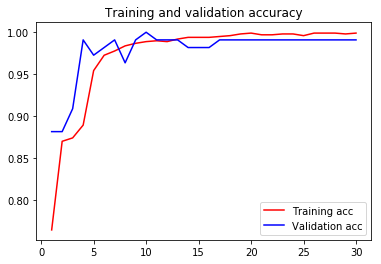

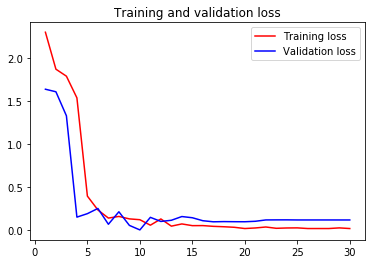

In [15]:
# Plot the history of accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [16]:
preds = model.predict(test_features)

## Plot confusion matrix

In [17]:
# Change labels from one-hot encoded
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]

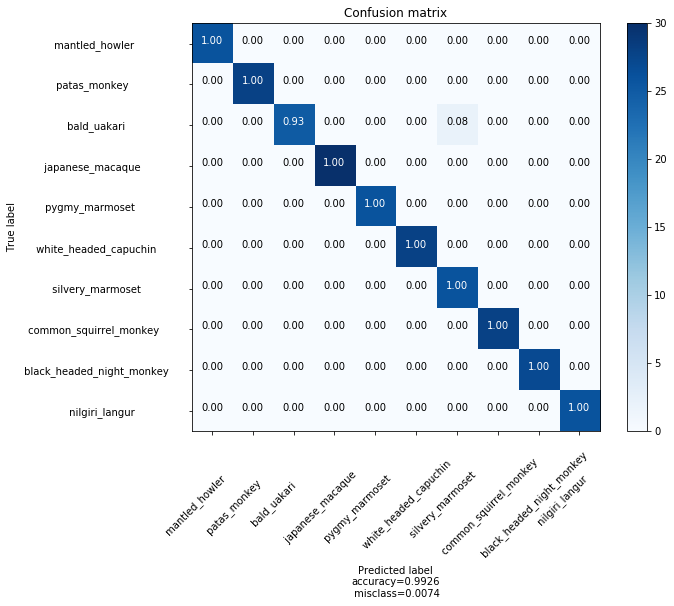

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=predictions, y_true=y_true)
plot_confusion_matrix(cm, normalize=True, target_names=labels)